<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author**
Nafis Neehal (661990881) \\
Graduate Student, Department of CS, RPI

#**Imports**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("./drive/MyDrive/ML Project Course/HW1/data.csv")

In [ ]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#**Data Analysls**

Observations:


*   Data has a mix of categorical, continuous and binary data
*   Data in highly disruptive different scales for - Age, Avg Glucose Level and BMI
* BMI has sufficient amount of missing values, discarding all will result in significant information loss



In [ ]:
data.work_type.unique(), data.Residence_type.unique(), data.smoking_status.unique()

(array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
       dtype=object),
 array(['Urban', 'Rural'], dtype=object),
 array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
       dtype=object))

Missing BMI value counts

In [ ]:
data.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [ ]:
data.bmi.isna().sum()

201

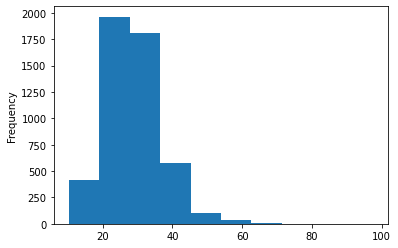

In [ ]:
data.bmi.plot(kind='hist')

#**Data Transformation**

Convert Categorical Data into numeric representations via mapping

In [ ]:
data.gender = data.gender.replace(["Male","Female", "Other"],[1,0,2])

In [ ]:
data.ever_married = data.ever_married.replace(["Yes","No"],[1,0])

In [ ]:
data.Residence_type = data.Residence_type.replace(["Urban","Rural"],[1,0])

Mapping for work_type feature: \\
0=Govt_Job, 1=Never_Worked , 2=Private, 3=Self Employed,  4=Children, 

In [ ]:
data.work_type = data.work_type.astype('category').cat.codes

Mapping for smoking_status feature: \\
0= 'Unknown', 1= 'formerly smoked', 2= 'never smoked', 3='smokes'

In [ ]:
data.smoking_status = data.smoking_status.astype('category').cat.codes

Replacing missing BMIs with its nearest neighbor's BMI value based on all features except BMI. ID is not a feature.

*   Divide data into two sets, one with where all BMI values are present (A) and other with all BMI values as Nans (B)
*   For each sample x in B, find the nearest neighbor x_n in A, and then replace x's BMI value with x_n's BMI value. It would be more robust though if we would have taken multiple neighbors and then take the average. But for this simple non-sophisticated problem, this simpler design choice performed just as well.



In [ ]:
nan_ids = data[data.bmi.isna()].index.values
non_nan_ids = np.setdiff1d(data.index.values, nan_ids)

In [ ]:
from sklearn.neighbors import NearestNeighbors
NB = NearestNeighbors(n_neighbors=1, radius=0.2)
query_db = data[data.index.isin(non_nan_ids)].loc[:,'gender':'smoking_status'].drop(columns=['bmi'])
NB.fit(query_db.values)
for id in nan_ids:
  nan_sample = data.loc[id,'gender':'smoking_status'].drop(labels=['bmi'])
  nb_index_val = NB.kneighbors(nan_sample.values.reshape(1,-1), n_neighbors=1, return_distance=False)
  nb_sample = data.loc[nb_index_val[-1],:]
  data.loc[id,'bmi'] = nb_sample.bmi.values[-1]

 Really make sure that somehow no more NaNs remain in data

In [ ]:

data = data.dropna()

Standardize three features that have disruptively different scale - age, avg_glucose_level and bmi.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
data[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(data[['age','avg_glucose_level', 'bmi']])
X = data.loc[:,'gender':'smoking_status'].values
Y = data.stroke.values.reshape(X.shape[0], 1)

Final Data is in far better shape now.

In [ ]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,1.052152,0,1,1,2,1,2.706635,0.991383,1,1
1,51676,0,0.786764,0,0,1,3,0,2.121798,0.786539,2,1
2,31112,1,1.627157,0,1,1,2,0,-0.004861,0.466471,2,1
3,60182,0,0.255990,0,0,1,2,1,1.437575,0.709723,3,1
4,1665,0,1.582926,1,0,1,3,0,1.501403,-0.621761,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,1.627157,1,0,1,2,1,-0.494507,0.709723,2,0
5106,44873,0,1.671388,0,0,1,3,1,0.420957,1.426675,2,0
5107,19723,0,-0.363247,0,0,1,3,0,-0.511292,0.223219,2,0
5108,37544,1,0.344452,0,0,1,2,0,1.328470,-0.416917,1,0


#**Scikit Learn Logistic Regression as Baseline**
This is just for test purpose - to check how our implementations perform compare to off the shelf implementation of logistic regression in Scikit Learn.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
%%time
from sklearn.metrics import accuracy_score
clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

tr_base = accuracy_score(y_train, y_train_pred)*100
te_base = accuracy_score(y_test, y_test_pred)*100
print(tr_base, te_base)

95.42227662178703 93.9334637964775
CPU times: user 24.3 ms, sys: 15.6 ms, total: 39.9 ms
Wall time: 41.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#**Functions**

In [ ]:
n = X_train.shape[0]
d = X_train.shape[1]

In [ ]:
"""
This function will calculate sigmoid function for given input.
"""

def sigmoid(a):
  return 1/(1+np.exp(-a))

In [ ]:
"""
This is the loss function. This will calculate the loss between the true and predicted labels. The original predicted values are clipped to a range so that we don't run into log(0)=undefined issue.
"""
def loss_function(Y,A,eps=1e-6):
    A = np.clip(A, eps, 1-eps)
    return -np.mean(Y * np.log(A) + (1-Y) * (np.log(1-A)))

In [ ]:
"""
This function will calculates the gradients
"""
def gradients(X,Y,A):
    dw = np.dot(X.T, A-Y)/X.shape[0]
    db = np.mean(A-Y)
    return dw, db

In [ ]:
"""
This function will returns the logistic model prediction given the input X and the model parameters (w,b).
"""
def predict(X, w, b):
  A = sigmoid(np.dot(X, w)+b)
  return A 

In [ ]:
"""
This function will create batches given X, Y and required batch size. We can use this function to return the whole batch or mini-batches.
"""
def create_batch_for_GD(X, Y, batch_size):
  
  num_samples = X.shape[0]
  num_of_batches = num_samples//batch_size
  batches = []

  data = np.concatenate((X,Y), axis=1)
  np.random.shuffle(data)
  
  for i in range(num_of_batches):
    batch = data[i*batch_size:(i+1)*batch_size]
    batches.append(batch)

  remaining_samples = num_samples%batch_size
  if remaining_samples>0:
    num_of_batches += 1
    batch = data[(i+1)*batch_size:]
    batches.append(batch)

  return batches


In [ ]:
"""
This function will runs the Gradient Descent algorithm in it's vanilla form - without any gradient optimization algorithm.
Here, we can just vary the batch size between n(number of training samples) and mini-batch-size and alter between Batch Gradient Descent and Mini-Batch Gradient Descent.
"""
def run_GD(epoch, lr, X, y, batch_size):
  epochs = epoch
  learning_rate = lr
  cost_history = []

  np.random.seed(0)
  w = np.zeros((d,1))
  b = np.zeros((1,1))

  for i in range(epochs):
    batches = create_batch_for_GD(X, y, batch_size= batch_size)
    
    for batch in batches:
      Xb, yb = batch[:,:-1], batch[:,-1]
      yb = yb.reshape(yb.shape[0],1)

      A = predict(Xb, w, b)

      cost = loss_function(yb, A)
      cost_history.append(cost)

      dw, db = gradients(Xb, yb, A)

      w = w - learning_rate * dw
      b = b - learning_rate * db

  return w, b, cost_history, len(batches) 


In [ ]:
"""
This function will runs the optimized Gradient Descent algorithm. 
Here, we can just vary the 'optimizer' parameter to any Tensorflow gradient optimizer. We have shown optimization for RMSProp and Adam. But we can see results for others too. 
You can also vary the batch_size to alter between mini-batch and batch GD. For optimized versions of GD, we optimized mini-batch gradient descent.
"""
import tensorflow as tf
def run_OPTIM_GD(optimizer, epochs, X, y, batch_size):
  W_t = tf.Variable(np.zeros((d,1)))
  b_t = tf.Variable(np.zeros((1,1)))
  
  W = W_t.numpy()
  b = b_t.numpy()

  losses = []
  optim = optimizer

  for i in range(epochs):
    batches = create_batch_for_GD(X, y, batch_size=batch_size)
    num_of_batches = len(batches)

    for batch in batches:
      Xb, yb = batch[:,:-1], batch[:,-1]
      yb = yb.reshape(yb.shape[0],1)
      A = predict(Xb, W, b)

      cost = loss_function(yb, A)
      losses.append(cost)
      
      dw, db = gradients(Xb, yb, A)
      optim.apply_gradients([(dw, W_t), (db.reshape(b_t.shape), b_t)])
      
      W = W_t.numpy()
      b = b_t.numpy()

  
  return W, b, losses, num_of_batches

In [ ]:
"""
This function runs performance analysis. It calculates the accuracy of the logistic model, as well as plots the infamous loss-VS-epoch curve.
"""
def performance_analysis(w, b, loss_history, epoch, num_of_batches, fig_title):
  
  iters = np.arange(epoch*num_of_batches)

  plt.xlabel("Total Updates")
  plt.ylabel("Loss Value")
  plt.title(fig_title)
  plt.plot(iters, loss_history)

  y_train_pred_gd = np.round(predict(X_train, w, b))
  y_test_pred_gd = np.round(predict(X_test, w, b))

  print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_gd)*100:0.5f} %, Test Accuracy: {accuracy_score(y_test, y_test_pred_gd)*100:0.5f} %")

  return accuracy_score(y_train, y_train_pred_gd)*100, accuracy_score(y_test, y_test_pred_gd)*100

# **Vanilla Gradient Descent Implementations (Batch, Mini-Batch)**

### Batch Gradient Descent

Training Accuracy: 95.42228 %, Test Accuracy: 93.93346 %
CPU times: user 14.4 s, sys: 11.5 s, total: 25.8 s
Wall time: 13.2 s


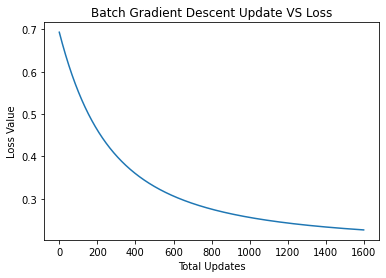

In [ ]:
%%time
#Batch Gradient Descent
NUM_EPOCH = 1600
w_bgd, b_bgd, loss_bgd, num_of_batches = run_GD(epoch=NUM_EPOCH, lr=0.001, X=X_train, y=y_train, batch_size=n)
tr_bgd, te_bgd = performance_analysis(w_bgd, b_bgd, loss_bgd, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="Batch Gradient Descent Update VS Loss")

### Mini-Batch Gradient Descent

Training Accuracy: 95.42228 %, Test Accuracy: 93.93346 %
CPU times: user 691 ms, sys: 12.7 ms, total: 704 ms
Wall time: 710 ms


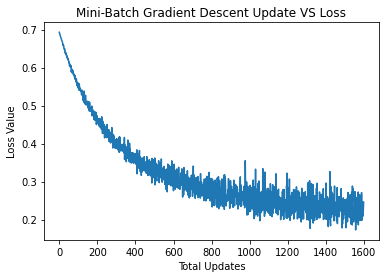

In [ ]:
%%time
#Mini-Batch Gradient Descent
NUM_EPOCH = 100
w_mgd, b_mgd, loss_mgd, num_of_batches = run_GD(epoch=NUM_EPOCH, lr=0.001, X=X_train, y=y_train, batch_size=256)
tr_mgd, te_mgd =performance_analysis(w_mgd, b_mgd, loss_mgd, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="Mini-Batch Gradient Descent Update VS Loss")

# **Optimized Gradient Descent with Tensorflow**

### RMSProp

Training Accuracy: 95.44676 %, Test Accuracy: 93.93346 %
CPU times: user 4.23 s, sys: 44.4 ms, total: 4.28 s
Wall time: 4.29 s


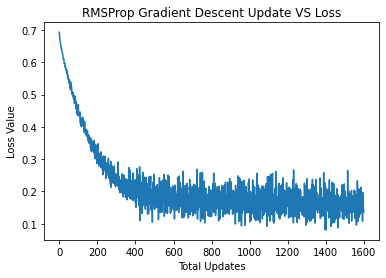

In [ ]:
%%time
NUM_EPOCH = 100
optim = tf.keras.optimizers.RMSprop(learning_rate=0.001)
W_rms, b_rms, loss_rms, num_of_batches = run_OPTIM_GD(optim, epochs=NUM_EPOCH, X=X_train, y=y_train, batch_size=256)
tr_rms, te_rms =performance_analysis(W_rms, b_rms, loss_rms, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="RMSProp Gradient Descent Update VS Loss")

### ADAM

Training Accuracy: 95.37332 %, Test Accuracy: 93.73777 %
CPU times: user 2.9 s, sys: 13.4 ms, total: 2.91 s
Wall time: 2.92 s


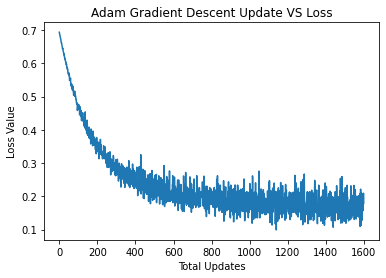

In [ ]:
%%time
NUM_EPOCH = 100
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
W_adam, b_adam, loss_adam, num_of_batches = run_OPTIM_GD(optim, epochs=NUM_EPOCH, X=X_train, y=y_train, batch_size=256)
tr_adam, te_adam =performance_analysis(W_adam, b_adam, loss_adam, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="Adam Gradient Descent Update VS Loss")

# **Result Summary and Discussion**

### Performance

In [ ]:
training_accuracy = [tr_base, tr_bgd, tr_mgd, tr_rms, tr_adam]
test_accuracy = [te_base, te_bgd, te_mgd, te_rms, te_adam]
models = ['Scikit Learn (Baseline)', 'Batch GD', 'Mini-Batch GD', 'RMSProp', 'ADAM']
time = ['41.8ms', '13.2s', '']
columns = ["Model Name", "Training Accuracy", "Test Accuracy"]
Results = pd.DataFrame({columns[0]:models,
                        columns[1]:training_accuracy,
                        columns[2]:test_accuracy})
Results

,Model Name,Training Accuracy,Test Accuracy
0,Scikit Learn (Baseline),95.422277,93.933464
1,Batch GD,95.422277,93.933464
2,Mini-Batch GD,95.422277,93.933464
3,RMSProp,95.446756,93.933464
4,ADAM,95.373317,93.737769


**Performance:** RMSProp seems to be outperforming all the versions of Gradient Descent including the baseline implementation in Scikit Learn, albeit by a very slight margin in training accuracy. For test accuracy, all were more or less same or at least very close (ADAM). In terms of performance
 




**Explaination for Spikes in Loss-VS-Epoch Graph:** As it can be seen, there are spikes in the loss-vs-epoch curves for vanilla mini-batch GD and for both RMSProp and ADAM. This is actually expected that there will be some form of variance because of the smaller mini-batch being used for training - so in every iteration we are training and updating on different smaller training sets. The more the batch_size increases, lesser the updates with smaller datasets, lesser variance till convergance and hence smoother the graph becomes. The Course Lecture by Professor Andrew Ng from Stanford actually explains this phenomenon - https://www.coursera.org/lecture/deep-neural-network/understanding-mini-batch-gradient-descent-lBXu8

**batch_size** = 64

Training Accuracy: 95.39780 %, Test Accuracy: 93.83562 %
CPU times: user 9.69 s, sys: 34 ms, total: 9.72 s
Wall time: 9.73 s


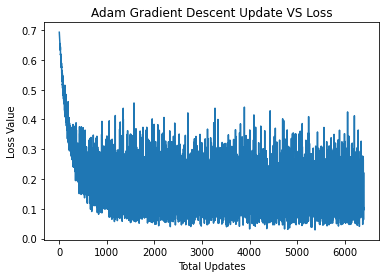

In [ ]:
%%time
NUM_EPOCH = 100
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
W_adam, b_adam, loss_adam, num_of_batches = run_OPTIM_GD(optim, epochs=NUM_EPOCH, X=X_train, y=y_train, batch_size=64)
tr_adam, te_adam =performance_analysis(W_adam, b_adam, loss_adam, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="Adam Gradient Descent Update VS Loss")

**batch_size** = 256

Training Accuracy: 95.37332 %, Test Accuracy: 93.73777 %
CPU times: user 2.86 s, sys: 11.9 ms, total: 2.87 s
Wall time: 2.87 s


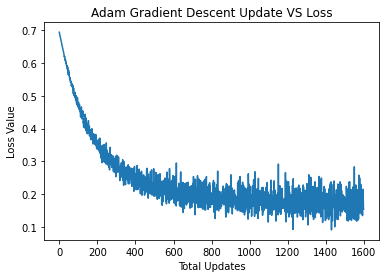

In [ ]:
%%time
NUM_EPOCH = 100
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
W_adam, b_adam, loss_adam, num_of_batches = run_OPTIM_GD(optim, epochs=NUM_EPOCH, X=X_train, y=y_train, batch_size=256)
tr_adam, te_adam =performance_analysis(W_adam, b_adam, loss_adam, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="Adam Gradient Descent Update VS Loss")

**batch_size** = 1024

Training Accuracy: 95.42228 %, Test Accuracy: 93.93346 %
CPU times: user 2.01 s, sys: 1.56 s, total: 3.57 s
Wall time: 1.87 s


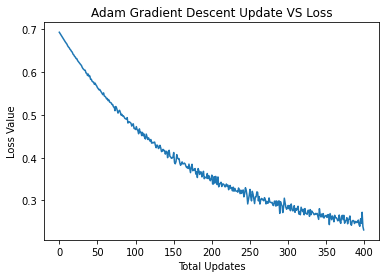

In [ ]:
%%time
NUM_EPOCH = 100
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
W_adam, b_adam, loss_adam, num_of_batches = run_OPTIM_GD(optim, epochs=NUM_EPOCH, X=X_train, y=y_train, batch_size=1024)
tr_adam, te_adam =performance_analysis(W_adam, b_adam, loss_adam, epoch=NUM_EPOCH, num_of_batches=num_of_batches, fig_title="Adam Gradient Descent Update VS Loss")

### Time

Text(0, 0.5, 'Time in millisecond but log-scale')

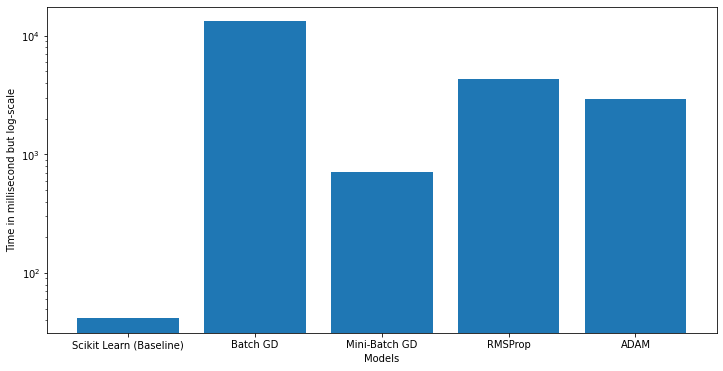

In [ ]:
time = [41.8, 13.2*1000, 710, 4.29*1000, 2.92*1000]
plt.figure(figsize=[12,6])
plt.bar(models, time, log=True)
plt.xlabel("Models")
plt.ylabel("Time in millisecond but log-scale")

**Time:** In terms of time, obviously the industrial grade optimized implementation of Scikit Learn takes the lowest amount of time. And among our implentations, Vanilla Mini-Batch GD takes the lowest amount of time. RMSProp and ADAM still takes lower amount of time than the Batch GD becuase of considering the number of samples to calculate in each epoch for gradient update. But RMSProp and ADAM takes a little bit higher time than Mini-Batch GD because of the momentum and other extra calculations for the purpose of optimization.

# Comment on which Algorithm to use and Why 
The dataset we worked with in this problem is quite small in size (5k samples). So performance analysis showing that all the algorithms are performing in almost a similar manner. The difference will become very prominent when dataset becomes very large (in Millions). Only then the true performance of these optimizers can be understood. But for this problem, any of the optimization algorithm, even the vanilla forms too will work fine.